In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import nltk 
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import torchvision

In [2]:
df = pd. read_csv('Symptom2Disease.csv')
df.head()

,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."


In [3]:
df['text']

0       I have been experiencing a skin rash on my arm...
1       My skin has been peeling, especially on my kne...
2       I have been experiencing joint pain in my fing...
3       There is a silver like dusting on my skin, esp...
4       My nails have small dents or pits in them, and...
                              ...                        
1195    I'm shaking and trembling all over. I've lost ...
1196    Particularly in the crevices of my skin, I hav...
1197    I regularly experience these intense urges and...
1198    I have trouble breathing, especially outside. ...
1199    I constantly sneeze and have a dry cough. My i...
Name: text, Length: 1200, dtype: object

In [4]:
df = df.drop(['Unnamed: 0'], axis=1)

In [5]:
df.isna().sum()

label    0
text     0
dtype: int64

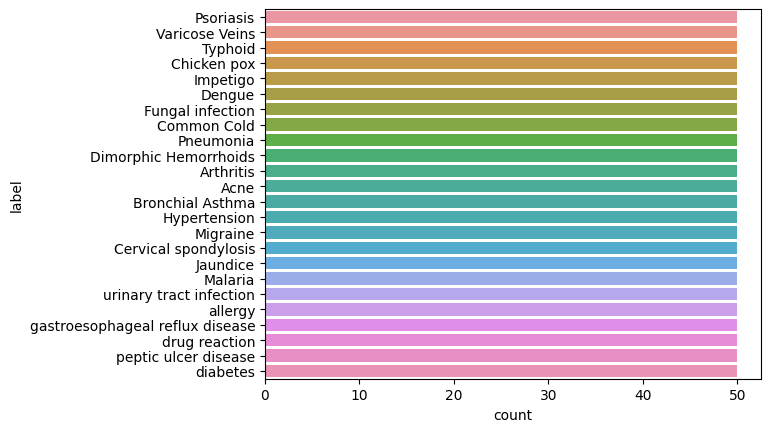

In [6]:
sns.countplot(y='label',data=df);

In [7]:
symptoms = df['text'].values

In [8]:
#switch all to lower case
symptoms = [str(sentence).lower() for sentence in symptoms]

In [9]:
len(symptoms)

1200

In [10]:
#bert tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertModel.from_pretrained('bert-base-uncased').to(device)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
from tqdm import tqdm

In [12]:
def embed_text(texts, batch_size=8):
    embeddings = []
    # Create a progress bar
    progress_bar = tqdm(range(0, len(texts), batch_size), desc="Processing text batches")
    
    for start_index in progress_bar:
        # Select batch of text
        end_index = start_index + batch_size
        batch_texts = texts[start_index:end_index]

        # Tokenize and encode the batch
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        
        # Move input tensors to the same device as the model
        inputs = {name: tensor.to(device) for name, tensor in inputs.items()}
        
        # Get the embeddings
        with torch.no_grad():
            outputs = model(**inputs)
        # Use the average of the last hidden state as the embedding
        batch_embeddings = outputs['last_hidden_state'].mean(dim=1).cpu()  # move to CPU here
        embeddings.append(batch_embeddings)
        
    # Concatenate all the embeddings
    embeddings = torch.cat(embeddings, dim=0)
    
    return embeddings

In [13]:
text_embeddings = embed_text(symptoms)

Processing text batches: 100%|██████████| 150/150 [00:03<00:00, 45.35it/s]


In [14]:
#encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(df['label'].values)


In [15]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [16]:
X,y = text_embeddings,labels

In [17]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=42)

In [18]:
#naive bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.8388888888888889


In [19]:
#sample prediction
print(le.inverse_transform(gnb.predict(text_embeddings[0].reshape(1,-1))))

['Psoriasis']


In [32]:
#sample input
input_symptom = 'a rash that turns into itchy, fluid-filled blisters that eventually turn into scabs'
input_symptom = [input_symptom.lower()]
input_embedding = embed_text(input_symptom, batch_size=1)

Processing text batches: 100%|██████████| 1/1 [00:00<00:00, 16.36it/s]


In [33]:
#sample prediction
print(le.inverse_transform(gnb.predict(input_embedding[0].reshape(1,-1))))

['drug reaction']


In [22]:
#try with a different model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.9166666666666666


In [34]:
#sample prediction
print(le.inverse_transform(rfc.predict(input_embedding[0].reshape(1,-1))))

['Impetigo']


In [24]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.8833333333333333


In [35]:
print(le.inverse_transform(xgb.predict(input_embedding[0].reshape(1,-1))))

['Impetigo']
